In [ ]:
!pip install hdbscan umap-learn plotly pandas numpy scikit-learn statsmodels -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
import hdbscan
import warnings
warnings.filterwarnings('ignore')
from math import pi
import umap

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')

In [ ]:
filename = '/content/Dataset.csv'

df = pd.read_csv(filename)

print(f"Loaded: {filename}")
print(f"\n Dataset shape: {df.shape}")
print(f"Rows: {df.shape[0]:,} | Columns: {df.shape[1]}")
print(f"Time period range: {df['TIME_PERIOD'].min()} - {df['TIME_PERIOD'].max()}")

Loaded: /content/Dataset.csv

 Dataset shape: (26208, 25)
Rows: 26,208 | Columns: 25
Time period range: 2019 - 2024


Dataset Overview

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26208 entries, 0 to 26207
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   TOPIC              26208 non-null  object 
 1   SUBTOPIC           1404 non-null   object 
 2   SUBTOPIC_ID        1404 non-null   float64
 3   TAXONOMY           26208 non-null  object 
 4   TAXONOMY_ID        26208 non-null  int64  
 5   CLASSIFICATION     26208 non-null  object 
 6   CLASSIFICATION_ID  26208 non-null  int64  
 7   GROUP              26208 non-null  object 
 8   GROUP_ID           26208 non-null  int64  
 9   GROUP_ORDER        26208 non-null  int64  
 10  SUBGROUP           26208 non-null  object 
 11  SUBGROUP_ID        26208 non-null  int64  
 12  SUBGROUP_ORDER     26208 non-null  int64  
 13  NESTING_LABEL      2016 non-null   object 
 14  NESTING_LABEL_ID   2016 non-null   float64
 15  ESTIMATE_TYPE      26208 non-null  object 
 16  ESTIMATE_TYPE_ID   262

In [ ]:
df.head(10)

,TOPIC,SUBTOPIC,SUBTOPIC_ID,TAXONOMY,TAXONOMY_ID,CLASSIFICATION,CLASSIFICATION_ID,GROUP,GROUP_ID,GROUP_ORDER,SUBGROUP,SUBGROUP_ID,SUBGROUP_ORDER,NESTING_LABEL,NESTING_LABEL_ID,ESTIMATE_TYPE,ESTIMATE_TYPE_ID,TIME_PERIOD,TIME_PERIOD_ID,ESTIMATE,STANDARD_ERROR,ESTIMATE_LCI,ESTIMATE_UCI,FLAG,FOOTNOTE_ID_LIST
0,Angina/angina pectoris,NaN,NaN,Cardiovascular diseases,60,Total,0,Total,1,1,18 years and older,1,1,NaN,NaN,"Percent of population, crude",1,2019,NaN,1.7,NaN,1.5,1.9,NaN,"NT_NHISA00,NT_NHISA999,FN_NHISA18,SC_NHISA00"
1,Angina/angina pectoris,NaN,NaN,Cardiovascular diseases,60,Total,0,Total,1,1,18 years and older,1,1,NaN,NaN,"Percent of population, crude",1,2020,NaN,1.5,NaN,1.3,1.6,NaN,"NT_NHISA00,NT_NHISA999,FN_NHISA18,SC_NHISA00"
2,Angina/angina pectoris,NaN,NaN,Cardiovascular diseases,60,Total,0,Total,1,1,18 years and older,1,1,NaN,NaN,"Percent of population, crude",1,2021,NaN,1.5,NaN,1.4,1.7,NaN,"NT_NHISA00,NT_NHISA999,FN_NHISA18,SC_NHISA00"
3,Angina/angina pectoris,NaN,NaN,Cardiovascular diseases,60,Total,0,Total,1,1,18 years and older,1,1,NaN,NaN,"Percent of population, crude",1,2022,NaN,1.6,NaN,1.5,1.8,NaN,"NT_NHISA00,NT_NHISA999,FN_NHISA18,SC_NHISA00"
4,Angina/angina pectoris,NaN,NaN,Cardiovascular diseases,60,Total,0,Total,1,1,18 years and older,1,1,NaN,NaN,"Percent of population, crude",1,2023,NaN,1.6,NaN,1.4,1.8,NaN,"NT_NHISA00,NT_NHISA999,FN_NHISA18,SC_NHISA00"
5,Angina/angina pectoris,NaN,NaN,Cardiovascular diseases,60,Total,0,Total,1,1,18 years and older,1,1,NaN,NaN,"Percent of population, crude",1,2024,NaN,1.6,NaN,1.4,1.8,NaN,"NT_NHISA00,NT_NHISA999,FN_NHISA18,SC_NHISA00"
6,Angina/angina pectoris,NaN,NaN,Cardiovascular diseases,60,Demographic Characteristic,1,Age groups with 65 years and older,2,2,18-34 years,2,2,NaN,NaN,"Percent of population, crude",1,2019,NaN,0.2,NaN,0.1,0.4,NaN,"NT_NHISA00,NT_NHISA999,FN_NHISA18,SC_NHISA00"
7,Angina/angina pectoris,NaN,NaN,Cardiovascular diseases,60,Demographic Characteristic,1,Age groups with 65 years and older,2,2,18-34 years,2,2,NaN,NaN,"Percent of population, crude",1,2020,NaN,0.3,NaN,0.1,0.6,NaN,"NT_NHISA00,NT_NHISA999,FN_NHISA18,SC_NHISA00"
8,Angina/angina pectoris,NaN,NaN,Cardiovascular diseases,60,Demographic Characteristic,1,Age groups with 65 years and older,2,2,18-34 years,2,2,NaN,NaN,"Percent of population, crude",1,2021,NaN,0.4,NaN,0.2,0.6,NaN,"NT_NHISA00,NT_NHISA999,FN_NHISA18,SC_NHISA00"
9,Angina/angina pectoris,NaN,NaN,Cardiovascular diseases,60,Demographic Characteristic,1,Age groups with 65 years and older,2,2,18-34 years,2,2,NaN,NaN,"Percent of population, crude",1,2022,NaN,0.2,NaN,0.1,0.4,NaN,"NT_NHISA00,NT_NHISA999,FN_NHISA18,SC_NHISA00"


In [ ]:
# Check Missing Values
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Percentage': missing_pct
}).sort_values('Missing Count', ascending=False)
print(missing_df[missing_df['Missing Count'] > 0])

                  Missing Count  Percentage
STANDARD_ERROR            26208  100.000000
TIME_PERIOD_ID            26208  100.000000
SUBTOPIC                  24804   94.642857
SUBTOPIC_ID               24804   94.642857
NESTING_LABEL_ID          24192   92.307692
NESTING_LABEL             24192   92.307692
FLAG                      23609   90.083181
ESTIMATE_LCI               2575    9.825244
ESTIMATE_UCI               2575    9.825244
ESTIMATE                   2369    9.039225


In [ ]:
# Check Key Columns
print(f"Topics: {df['TOPIC'].nunique()} unique")
print(f"Time periods: {sorted(df['TIME_PERIOD'].dropna().unique())}")
print(f"Groups: {df['GROUP'].nunique()} unique")
print(f"Subgroups: {df['SUBGROUP'].nunique()} unique")
print(f"\nTop 10 Topics:")
print(df['TOPIC'].value_counts().head(10))

Topics: 54 unique
Time periods: [np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024)]
Groups: 21 unique
Subgroups: 75 unique

Top 10 Topics:
TOPIC
Urgent care center or retail health clinic visit among adults:    1404
Angina/angina pectoris                                             468
Any difficulty communicating                                       468
Any difficulty hearing                                             468
Any difficulty remembering or concentrating                        468
Any cancer type                                                    468
Any difficulty walking or climbing steps                           468
Any difficulty with self care                                      468
Any skin cancer                                                    468
Arthritis diagnosis                                                468
Name: count, dtype: int64


In [ ]:
# Delayed care topics
print("\n DELAYED CARE TOPICS:")
delayed_mask = df['TOPIC'].str.contains('delay|wait|postpone', case=False, na=False)
delayed_topics = df[delayed_mask]['TOPIC'].unique()
print(f"Found {len(delayed_topics)} topics:")
for topic in delayed_topics:
    count = len(df[df['TOPIC'] == topic])
    print(f"  • {topic} ({count:,} rows)")

# Unmet needs topics
print("\n UNMET NEEDS TOPICS:")
unmet_mask = df['TOPIC'].str.contains('unmet|unable|could not|did not get|needed but|did not take', case=False, na=False)
unmet_topics = df[unmet_mask]['TOPIC'].unique()
print(f"Found {len(unmet_topics)} topics:")
for topic in unmet_topics:
    count = len(df[df['TOPIC'] == topic])
    print(f"  • {topic} ({count:,} rows)")

# Define access topics for later use
access_topics = list(delayed_topics) + list(unmet_topics)
print(f"\n Total access/barrier topics: {len(access_topics)}")

# Health conditions (everything else)
print("\n HEALTH CONDITION TOPICS (sample):")
condition_mask = ~(delayed_mask | unmet_mask)
condition_topics = df[condition_mask]['TOPIC'].unique()
print(f"Found {len(condition_topics)} condition topics (showing first 15):")
for topic in condition_topics[:15]:
    print(f"  • {topic}")



 DELAYED CARE TOPICS:
Found 1 topics:
  • Delayed getting medical care due to cost among adults (468 rows)

 UNMET NEEDS TOPICS:
Found 3 topics:
  • Did not get needed medical care due to cost (468 rows)
  • Did not get needed mental health care due to cost (468 rows)
  • Did not take medication as prescribed to save money (468 rows)

 Total access/barrier topics: 4

 HEALTH CONDITION TOPICS (sample):
Found 50 condition topics (showing first 15):
  • Angina/angina pectoris
  • Any cancer type
  • Any difficulty communicating
  • Any difficulty hearing
  • Any difficulty remembering or concentrating
  • Any difficulty seeing
  • Any difficulty walking or climbing steps
  • Any difficulty with self care
  • Any skin cancer
  • Arthritis diagnosis
  • Asthma episode/attack in adults
  • Blood pressure check
  • Breast cancer
  • COPD, emphysema, chronic bronchitis
  • Cervical cancer


In [ ]:
print(f"Rows with flags: {df['FLAG'].notna().sum():,}")
print(f"Rows without flags: {df['FLAG'].isna().sum():,}")
if df['FLAG'].notna().sum() > 0:
    print(f"\nFlag types:")
    print(df['FLAG'].value_counts())

Rows with flags: 2,599
Rows without flags: 23,609

Flag types:
FLAG
---     978
*       629
****    546
***     216
-       206
~        16
**        8
Name: count, dtype: int64


Data Cleaning

In [ ]:
# Remove Unnecessary Columns
columns_to_drop = [
    'STANDARD_ERROR',           # 100% missing
    'TIME_PERIOD_ID',           # 100% missing
    'SUBTOPIC',                 # 95% missing
    'SUBTOPIC_ID',              # 95% missing
    'NESTING_LABEL',            # 92% missing
    'NESTING_LABEL_ID',         # 92% missing
    'FOOTNOTE_ID_LIST',         # Not useful
    'TAXONOMY_ID',              # Redundant
    'CLASSIFICATION_ID',        # Redundant
    'GROUP_ID',                 # Redundant
    'GROUP_ORDER',              # Not needed
    'SUBGROUP_ID',              # Redundant
    'SUBGROUP_ORDER',           # Not needed
    'ESTIMATE_TYPE_ID'          # Redundant
]

df_clean = df.drop(columns=columns_to_drop, errors='ignore').copy()

print(f"Original columns: {len(df.columns)}")
print(f"New columns: {len(df_clean.columns)}")


Original columns: 25
New columns: 11


In [ ]:
# Remove unreliable rows
df_clean = df_clean[df_clean['FLAG'].isna()].copy()
df_clean = df_clean[df_clean['ESTIMATE'].notna()].copy()
df_clean = df_clean[df_clean['CLASSIFICATION'] != 'Total'].copy()

print(f"Original dataset: {len(df_clean):,} rows")
print(f"Final cleaned dataset: {len(df_clean):,} rows ({(len(df_clean)/len(df)*100):.1f}% retained)")

Original dataset: 23,291 rows
Final cleaned dataset: 23,291 rows (88.9% retained)


In [ ]:
# Seperate Access Barriers From Health Conditions
access_topics = [
    'Delayed getting medical care due to cost among adults',
    'Did not get needed medical care due to cost',
    'Did not get needed mental health care due to cost',
    'Did not take medication as prescribed to save money'
]

df_clean['ci_width'] = df_clean['ESTIMATE_UCI'] - df_clean['ESTIMATE_LCI']
df_clean['relative_ci_width'] = df_clean['ci_width'] / df_clean['ESTIMATE'].replace(0, np.nan)
df_clean['relative_ci_width'] = df_clean['relative_ci_width'].replace([np.inf, -np.inf], np.nan)

df_access = df_clean[df_clean['TOPIC'].isin(access_topics)].copy()
df_conditions = df_clean[~df_clean['TOPIC'].isin(access_topics)].copy()

print(f"Access/barriers data: {len(df_access):,} rows ({len(df_access)/len(df_clean)*100:.1f}%)")
print(f"Health conditions data: {len(df_conditions):,} rows ({len(df_conditions)/len(df_clean)*100:.1f}%)")


Access/barriers data: 1,779 rows (7.6%)
Health conditions data: 21,512 rows (92.4%)


In [ ]:
# Calculate Temporal Features

df_clean = df_clean.sort_values(['SUBGROUP', 'TOPIC', 'TIME_PERIOD'])

# Year-over-year change
df_clean['yoy_change'] = df_clean.groupby(['SUBGROUP', 'TOPIC'])['ESTIMATE'].diff()
df_clean['yoy_pct_change'] = df_clean.groupby(['SUBGROUP', 'TOPIC'])['ESTIMATE'].pct_change() * 100

df_clean['rolling_avg_3yr'] = df_clean.groupby(['SUBGROUP', 'TOPIC'])['ESTIMATE'].transform(
    lambda x: x.rolling(window=3, min_periods=1).mean()
)

# Volatility (standard deviation over time)
df_clean['volatility'] = df_clean.groupby(['SUBGROUP', 'TOPIC'])['ESTIMATE'].transform('std')

# Acceleration (second derivative)
df_clean['acceleration'] = df_clean.groupby(['SUBGROUP', 'TOPIC'])['yoy_change'].diff()

df_access = df_clean[df_clean['TOPIC'].isin(access_topics)].copy()
df_conditions = df_clean[~df_clean['TOPIC'].isin(access_topics)].copy()

sample = df_access[df_access['TOPIC'] == 'Delayed getting medical care due to cost among adults'].head(12)
print(sample[['SUBGROUP', 'TIME_PERIOD', 'ESTIMATE', 'yoy_change', 'yoy_pct_change', 'volatility']].to_string(index=False))

         SUBGROUP  TIME_PERIOD  ESTIMATE  yoy_change  yoy_pct_change  volatility
100% to <200% FPL         2019      14.9         NaN             NaN    1.724819
100% to <200% FPL         2020      12.1        -2.8      -18.791946    1.724819
100% to <200% FPL         2021       9.6        -2.5      -20.661157    1.724819
100% to <200% FPL         2022      11.3         1.7       17.708333    1.724819
100% to <200% FPL         2023      11.5         0.2        1.769912    1.724819
100% to <200% FPL         2024      11.7         0.2        1.739130    1.724819
      18-34 years         2019      10.5         NaN             NaN    1.015218
      18-34 years         2020       9.1        -1.4      -13.333333    1.015218
      18-34 years         2021       8.7        -0.4       -4.395604    1.015218
      18-34 years         2022       8.3        -0.4       -4.597701    1.015218
      18-34 years         2023       8.7         0.4        4.819277    1.015218
      18-34 years         20

In [ ]:
# Aggregate Access Metrics by Subgroup
access_metrics = df_access.groupby('SUBGROUP').agg({
    'ESTIMATE': ['mean', 'std', 'min', 'max'],
    'ci_width': 'mean',
    'yoy_change': 'mean',
    'volatility': 'mean'
}).reset_index()

access_metrics.columns = ['_'.join(col).strip('_') for col in access_metrics.columns.values]
access_metrics.columns = ['SUBGROUP', 'avg_access_barrier', 'std_access_barrier',
                          'min_access_barrier', 'max_access_barrier',
                          'avg_ci_width', 'avg_yoy_change', 'avg_volatility']

print("Top 10 subgroups by average access barrier:")
print(access_metrics.nlargest(10, 'avg_access_barrier')[['SUBGROUP', 'avg_access_barrier', 'std_access_barrier']].to_string(index=False))


Top 10 subgroups by average access barrier:
                                      SUBGROUP  avg_access_barrier  std_access_barrier
                                     Uninsured           21.492000            7.154248
                                      Bisexual           19.933333            3.848960
Native Hawaiian or Other Pacific Islander only           16.366667            3.163332
                               Black and White           13.018182            2.917814
                               With disability           12.212500            2.497357
   American Indian and Alaska Native and White           11.565000            3.551912
                         Living with a partner           11.308333            2.213774
                                     <100% FPL           10.950000            3.097404
                             100% to <200% FPL           10.383333            2.958946
                         Divorced or separated            9.537500            2.572397

In [ ]:
# Aggregate Health Conditon Metrics by Subgroup
condition_metrics = df_conditions.groupby('SUBGROUP').agg({
    'ESTIMATE': ['mean', 'std', 'count'],
    'yoy_change': 'mean',
    'volatility': 'mean'
}).reset_index()

condition_metrics.columns = ['_'.join(col).strip('_') for col in condition_metrics.columns.values]
condition_metrics.columns = ['SUBGROUP', 'avg_condition_prevalence', 'std_condition_prevalence',
                             'num_conditions', 'avg_condition_yoy_change', 'avg_condition_volatility']

print("\nTop 10 subgroups by average condition prevalence:")
print(condition_metrics.nlargest(10, 'avg_condition_prevalence')[['SUBGROUP', 'avg_condition_prevalence', 'num_conditions']].to_string(index=False))


Top 10 subgroups by average condition prevalence:
                                      SUBGROUP  avg_condition_prevalence  num_conditions
                               With disability                 37.465646             294
                         Medicare and Medicaid                 34.880159             252
Native Hawaiian or Other Pacific Islander only                 33.532308             130
                            75 years and older                 32.227907             258
                     Other government coverage                 30.495420             524
                                       Widowed                 30.141837             294
                            Medicare Advantage                 29.938372             258
                            65 years and older                 29.936047             258
   American Indian and Alaska Native and White                 29.495902             244
                 With functioning difficulties             

In [ ]:
# Create Master Feature Matrix
feature_matrix = access_metrics.merge(condition_metrics, on='SUBGROUP', how='outer')
feature_matrix = feature_matrix.fillna(0)
print(f"Shape: {feature_matrix.shape}")
print(feature_matrix.describe().T)

Shape: (74, 13)
                          count        mean        std         min  \
avg_access_barrier         74.0    7.388090   3.351161    1.712500   
std_access_barrier         74.0    1.907196   0.960594    0.809321   
min_access_barrier         74.0    4.102703   2.362897    0.200000   
max_access_barrier         74.0   10.948649   4.707739    3.700000   
avg_ci_width               74.0    2.623465   3.154179    0.775000   
avg_yoy_change             74.0   -0.119716   0.274221   -1.168750   
avg_volatility             74.0    1.127640   0.611025    0.387783   
avg_condition_prevalence   74.0   23.411245   4.176751   17.664685   
std_condition_prevalence   74.0   24.017683   2.167521   20.652503   
num_conditions             74.0  290.702703  47.635525  130.000000   
avg_condition_yoy_change   74.0    0.078422   0.200993   -0.898577   
avg_condition_volatility   74.0    1.476852   1.056184    0.815533   

                                 25%         50%         75%         max 

Validate Data Quality Before Clustering

Missing values in feature matrix:
No missing values

Infinite values check:
No infinite values


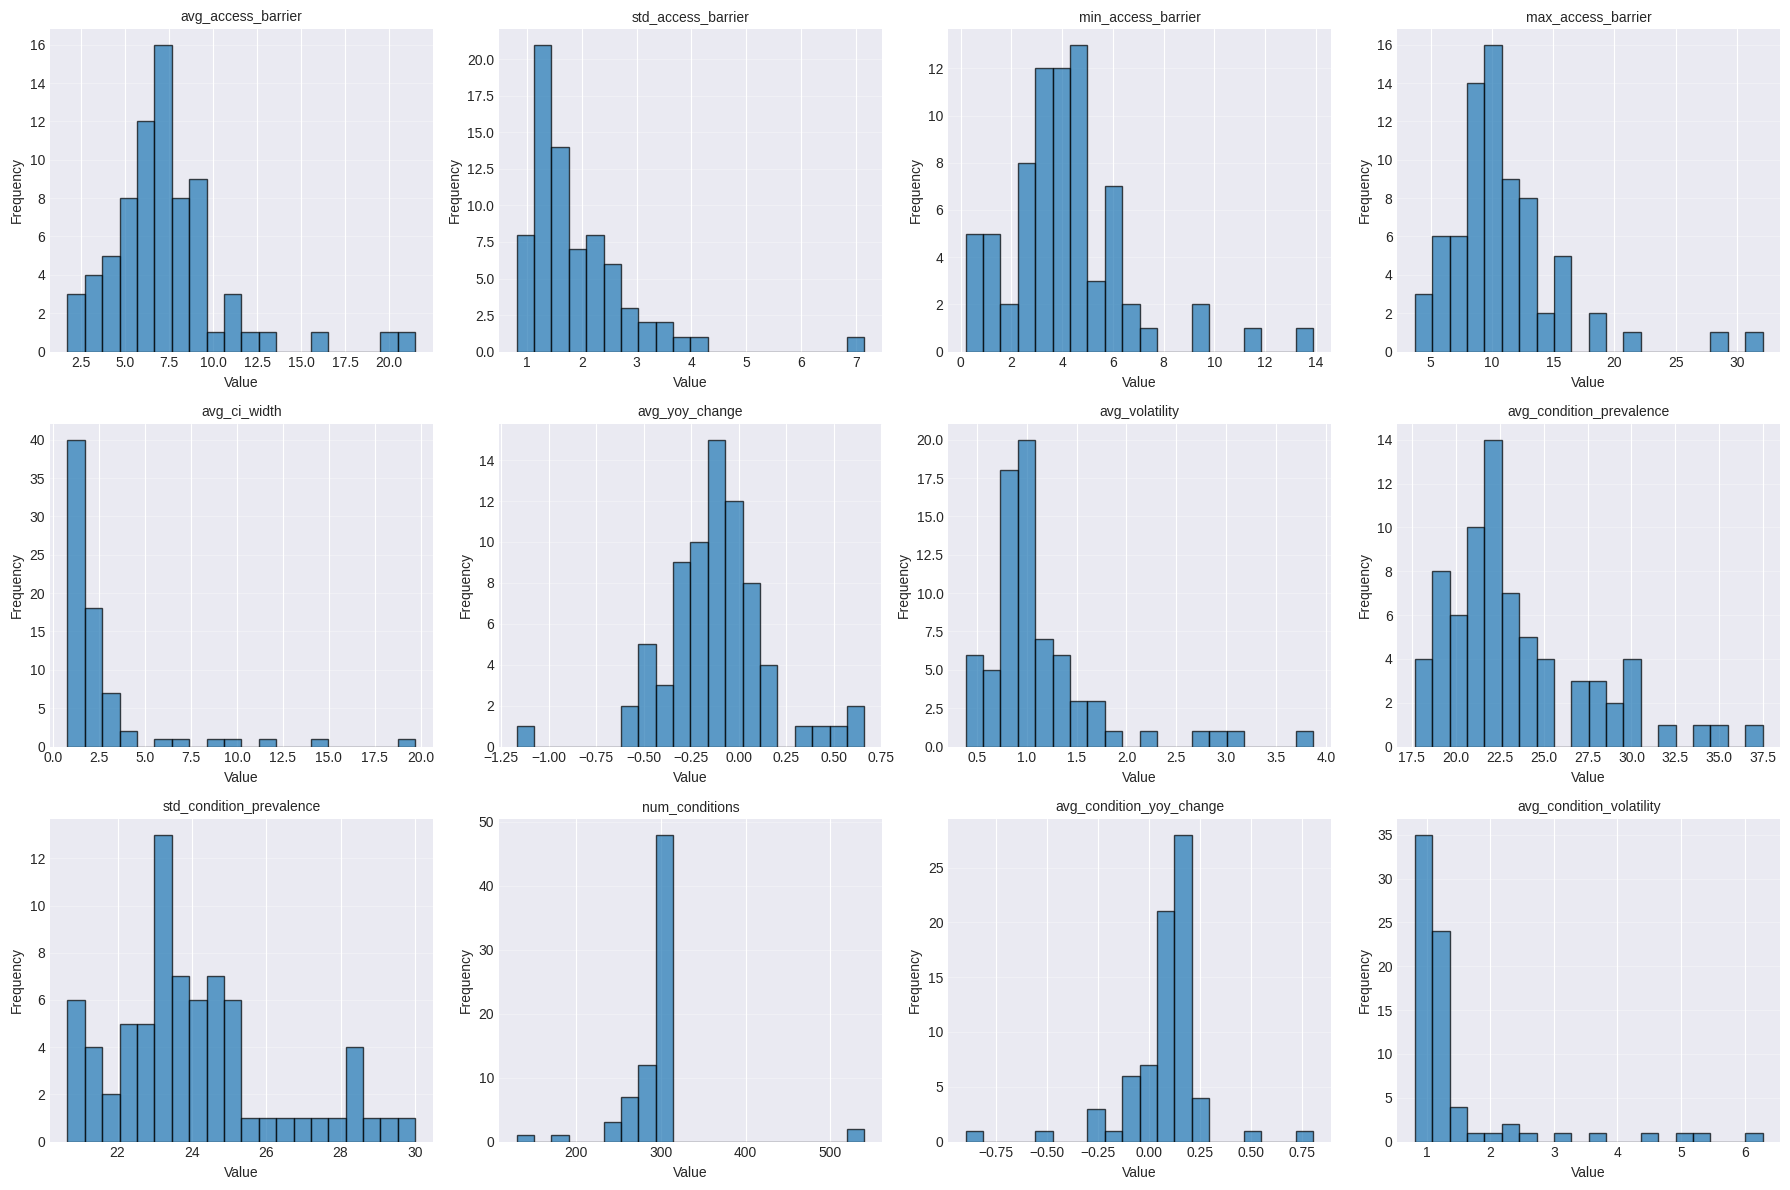

In [ ]:
# Check for missing values
print("Missing values in feature matrix:")
missing_in_features = feature_matrix.isnull().sum()
if missing_in_features.sum() == 0:
    print("No missing values")
else:
    print(missing_in_features[missing_in_features > 0])

# Check for infinite values
print("\nInfinite values check:")
numeric_cols = feature_matrix.select_dtypes(include=[np.number]).columns
inf_check = np.isinf(feature_matrix[numeric_cols]).sum()
if inf_check.sum() == 0:
    print("No infinite values")
else:
    print(inf_check[inf_check > 0])

# Check feature distributions
fig, axes = plt.subplots(3, 4, figsize=(18, 12))
axes = axes.flatten()

numeric_features = [col for col in feature_matrix.columns if col != 'SUBGROUP']

for i, col in enumerate(numeric_features):
    if i < len(axes):
        axes[i].hist(feature_matrix[col], bins=20, edgecolor='black', alpha=0.7)
        axes[i].set_title(col, fontsize=10)
        axes[i].set_xlabel('Value')
        axes[i].set_ylabel('Frequency')
        axes[i].grid(axis='y', alpha=0.3)

# Hide unused subplots
for i in range(len(numeric_features), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()


In [ ]:
# Prepare data for clustering
subgroup_names = feature_matrix['SUBGROUP'].values
X = feature_matrix.drop('SUBGROUP', axis=1)
print(f"Feature matrix shape: {X.shape}")
print(f"Features being used:")
for i, col in enumerate(feature_matrix.drop('SUBGROUP', axis=1).columns, 1):
    print(f"  {i}. {col}")

Feature matrix shape: (74, 12)
Features being used:
  1. avg_access_barrier
  2. std_access_barrier
  3. min_access_barrier
  4. max_access_barrier
  5. avg_ci_width
  6. avg_yoy_change
  7. avg_volatility
  8. avg_condition_prevalence
  9. std_condition_prevalence
  10. num_conditions
  11. avg_condition_yoy_change
  12. avg_condition_volatility


In [ ]:
# Standardize Features
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)
print(f"Standardized feature matrix shape: {X_scaled.shape}")

# Dimensionality Reduction with UMAP (For Visualization Only)
reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    metric='euclidean',
    random_state=42
)

embedding = reducer.fit_transform(X_scaled)
print(f"UMAP embedding created: {embedding.shape}")

Standardized feature matrix shape: (74, 12)
UMAP embedding created: (74, 2)


In [ ]:
# HDBSCAN clustering on FULL feature space
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=5,
    min_samples=3,
    cluster_selection_epsilon=0.0,
    metric='euclidean',
    cluster_selection_method='eom'
)

cluster_labels = clusterer.fit_predict(X_scaled)

n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
n_noise = list(cluster_labels).count(-1)

print(f"Clusters found: {n_clusters}")
print(f"Noise points (outliers): {n_noise}")
print(f"Clustered subgroups: {len(cluster_labels) - n_noise}")


Clusters found: 2
Noise points (outliers): 11
Clustered subgroups: 63


In [ ]:
for cluster_id in sorted(set(cluster_labels)):
    count = (cluster_labels == cluster_id).sum()
    if cluster_id == -1:
        print(f"Cluster -1 (NOISE/OUTLIERS): {count} subgroups")
    else:
        print(f"Cluster {cluster_id}: {count} subgroups")

Cluster -1 (NOISE/OUTLIERS): 11 subgroups
Cluster 0: 56 subgroups
Cluster 1: 7 subgroups


In [ ]:
feature_matrix['cluster'] = cluster_labels

for cluster_id in sorted(set(cluster_labels)):
    print(f"\nCLUSTER {cluster_id}:")
    cluster_subgroups = feature_matrix[feature_matrix['cluster'] == cluster_id]['SUBGROUP'].tolist()
    for sg in cluster_subgroups:
        print(f"  • {sg}")


CLUSTER -1:
  • American Indian and Alaska Native and White
  • American Indian and Alaska Native only
  • Bisexual
  • Black and White
  • Gay or Lesbian
  • Native Hawaiian or Other Pacific Islander only
  • Not employed - Has never worked
  • Other government coverage
  • Private
  • Uninsured
  • With disability

CLUSTER 0:
  • 100% to <200% FPL
  • 18-34 years
  • 18-44 years
  • 35-49 years
  • 45-64 years
  • 50-64 years
  • <100% FPL
  • All races, Hispanic
  • All races, Hispanic, Mexican
  • All races, non-Hispanic
  • Asian only
  • Black only
  • Black only, non-Hispanic
  • College degree or higher
  • Divorced or separated
  • Employed
  • Employed - Full-time
  • Employed - Part-time
  • Female
  • Foreign-born
  • High school diploma or GED
  • High social vulnerability
  • Large MSA
  • Large central metro
  • Large fringe metro
  • Little to no social vulnerability
  • Living with a partner
  • Low social vulnerability
  • Male
  • Married
  • Medicaid or other state

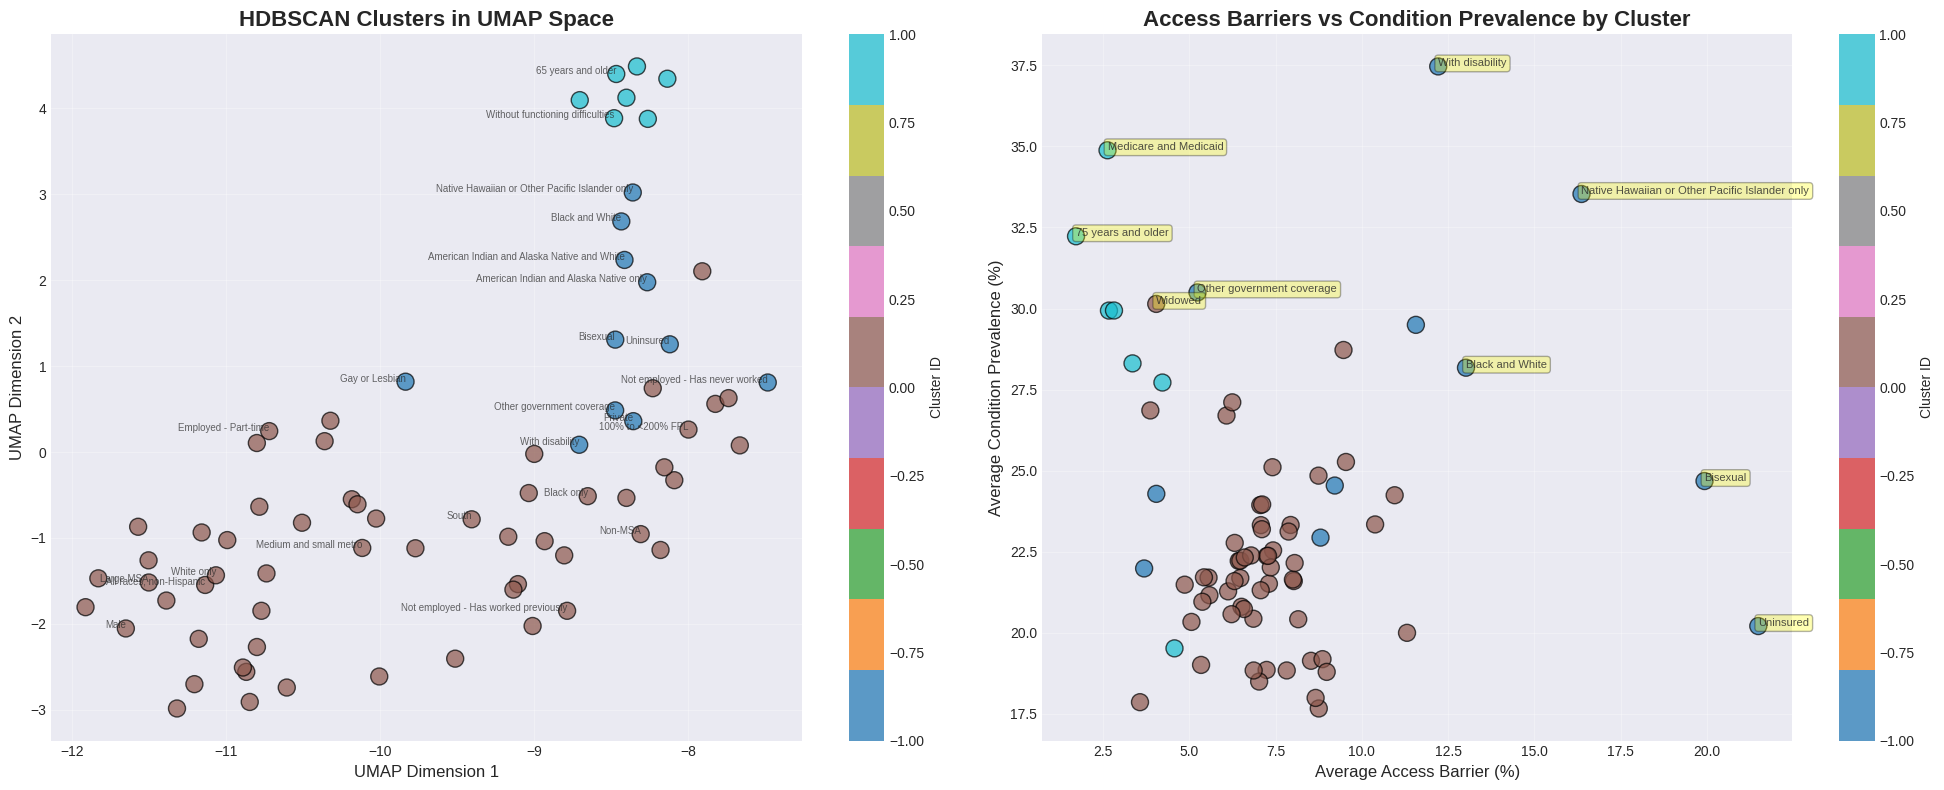

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Plot 1: Clusters in UMAP space
scatter1 = axes[0].scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=cluster_labels,
    cmap='tab10',
    s=150,
    alpha=0.7,
    edgecolors='black',
    linewidth=1
)
axes[0].set_title('HDBSCAN Clusters in UMAP Space', fontsize=16, fontweight='bold')
axes[0].set_xlabel('UMAP Dimension 1', fontsize=12)
axes[0].set_ylabel('UMAP Dimension 2', fontsize=12)
axes[0].grid(True, alpha=0.3)

for i, txt in enumerate(subgroup_names):
    if cluster_labels[i] == -1 or i % 6 == 0:
        axes[0].annotate(
            txt,
            (embedding[i, 0], embedding[i, 1]),
            fontsize=7,
            alpha=0.7,
            ha='right'
        )

plt.colorbar(scatter1, ax=axes[0], label='Cluster ID')

# Plot 2: Access Barrier vs Condition Prevalence
scatter2 = axes[1].scatter(
    feature_matrix['avg_access_barrier'],
    feature_matrix['avg_condition_prevalence'],
    c=cluster_labels,
    cmap='tab10',
    s=150,
    alpha=0.7,
    edgecolors='black',
    linewidth=1
)
axes[1].set_title('Access Barriers vs Condition Prevalence by Cluster', fontsize=16, fontweight='bold')
axes[1].set_xlabel('Average Access Barrier (%)', fontsize=12)
axes[1].set_ylabel('Average Condition Prevalence (%)', fontsize=12)
axes[1].grid(True, alpha=0.3)

for i, txt in enumerate(subgroup_names):
    if (feature_matrix['avg_access_barrier'].iloc[i] > 12 or
        feature_matrix['avg_condition_prevalence'].iloc[i] > 30):
        axes[1].annotate(
            txt,
            (feature_matrix['avg_access_barrier'].iloc[i],
             feature_matrix['avg_condition_prevalence'].iloc[i]),
            fontsize=8,
            alpha=0.8,
            ha='left',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.3)
        )

plt.colorbar(scatter2, ax=axes[1], label='Cluster ID')
plt.tight_layout()
plt.show()

CALCULATE HEALTHCARE ACCESS INEQUITY INDEX (HAII)

In [ ]:
# Calculate baseline (population average)
baseline = {
    'avg_access_barrier': feature_matrix['avg_access_barrier'].mean(),
    'avg_condition_prevalence': feature_matrix['avg_condition_prevalence'].mean(),
    'avg_yoy_change': feature_matrix['avg_yoy_change'].mean(),
    'avg_ci_width': feature_matrix['avg_ci_width'].mean(),
    'avg_volatility': feature_matrix['avg_volatility'].mean()
}

print("Baseline (Population Averages):")
for key, val in baseline.items():
    print(f"  {key}: {val:.2f}")

def calculate_HAII(row, baseline):
    # Component 1: Access barrier gap (30% weight)
    access_gap = (row['avg_access_barrier'] - baseline['avg_access_barrier']) / baseline['avg_access_barrier']
    access_gap = max(0, access_gap)

    # Component 2: Condition prevalence gap (25% weight)
    prevalence_gap = (row['avg_condition_prevalence'] - baseline['avg_condition_prevalence']) / baseline['avg_condition_prevalence']
    prevalence_gap = max(0, prevalence_gap)

    # Component 3: Deterioration trend (20% weight)
    # Negative yoy_change = getting worse
    deterioration = -row['avg_yoy_change'] if row['avg_yoy_change'] < 0 else 0

    # Component 4: Volatility/uncertainty (15% weight)
    volatility = row['avg_volatility'] / baseline['avg_volatility']

    # Component 5: Data quality penalty (10% weight)
    quality_penalty = row['avg_ci_width'] / baseline['avg_ci_width']

    HAII = (
        30 * min(access_gap * 100, 100) +
        25 * min(prevalence_gap * 100, 100) +
        20 * min(deterioration * 20, 100) +
        15 * min(volatility * 50, 100) +
        10 * min(quality_penalty * 50, 100)
    ) / 100

    return HAII

# Calculate HAII for each subgroup
feature_matrix['HAII'] = feature_matrix.apply(
    lambda row: calculate_HAII(row, baseline),
    axis=1
)

def classify_severity(haii):
    if haii < 25:
        return 'Low'
    elif haii < 50:
        return 'Moderate'
    elif haii < 75:
        return 'High'
    else:
        return 'Critical'

feature_matrix['HAII_severity'] = feature_matrix['HAII'].apply(classify_severity)
print(feature_matrix['HAII'].describe())

Baseline (Population Averages):
  avg_access_barrier: 7.39
  avg_condition_prevalence: 23.41
  avg_yoy_change: -0.12
  avg_ci_width: 2.62
  avg_volatility: 1.13
count    74.000000
mean     17.181909
std      13.028626
min       6.467441
25%       8.592635
50%      12.078237
75%      20.381819
max      58.145254
Name: HAII, dtype: float64


In [ ]:
print(feature_matrix['HAII_severity'].value_counts().sort_index())

HAII_severity
High         5
Low         61
Moderate     8
Name: count, dtype: int64


In [ ]:
# Overall statistics
severity_counts = feature_matrix['HAII_severity'].value_counts()
print(f"\nSeverity Summary:")
for severity in ['Low', 'Moderate', 'High', 'Critical']:
    if severity in severity_counts.index:
        count = severity_counts[severity]
        pct = (count / len(feature_matrix)) * 100
        print(f"  {severity}: {count} subgroups ({pct:.1f}%)")


Severity Summary:
  Low: 61 subgroups (82.4%)
  Moderate: 8 subgroups (10.8%)
  High: 5 subgroups (6.8%)


In [ ]:
print("TOP 20 MOST VULNERABLE POPULATIONS (BY HAII)")

top_20 = feature_matrix.nlargest(20, 'HAII')[[
    'SUBGROUP', 'HAII', 'HAII_severity', 'cluster',
    'avg_access_barrier', 'avg_condition_prevalence',
    'avg_yoy_change', 'avg_volatility'
]]

print(top_20.to_string(index=False))

TOP 20 MOST VULNERABLE POPULATIONS (BY HAII)
                                      SUBGROUP      HAII HAII_severity  cluster  avg_access_barrier  avg_condition_prevalence  avg_yoy_change  avg_volatility
Native Hawaiian or Other Pacific Islander only 58.145254          High       -1           16.366667                 33.532308       -0.266667        0.942809
                                     Uninsured 56.923810          High       -1           21.492000                 20.206338       -0.480952        3.163641
                                      Bisexual 56.354271          High       -1           19.933333                 24.679452        0.330000        2.801718
   American Indian and Alaska Native and White 53.133298          High       -1           11.565000                 29.495902       -1.168750        2.941001
                               Black and White 50.048661          High       -1           13.018182                 28.174211        0.571429        1.819405
       

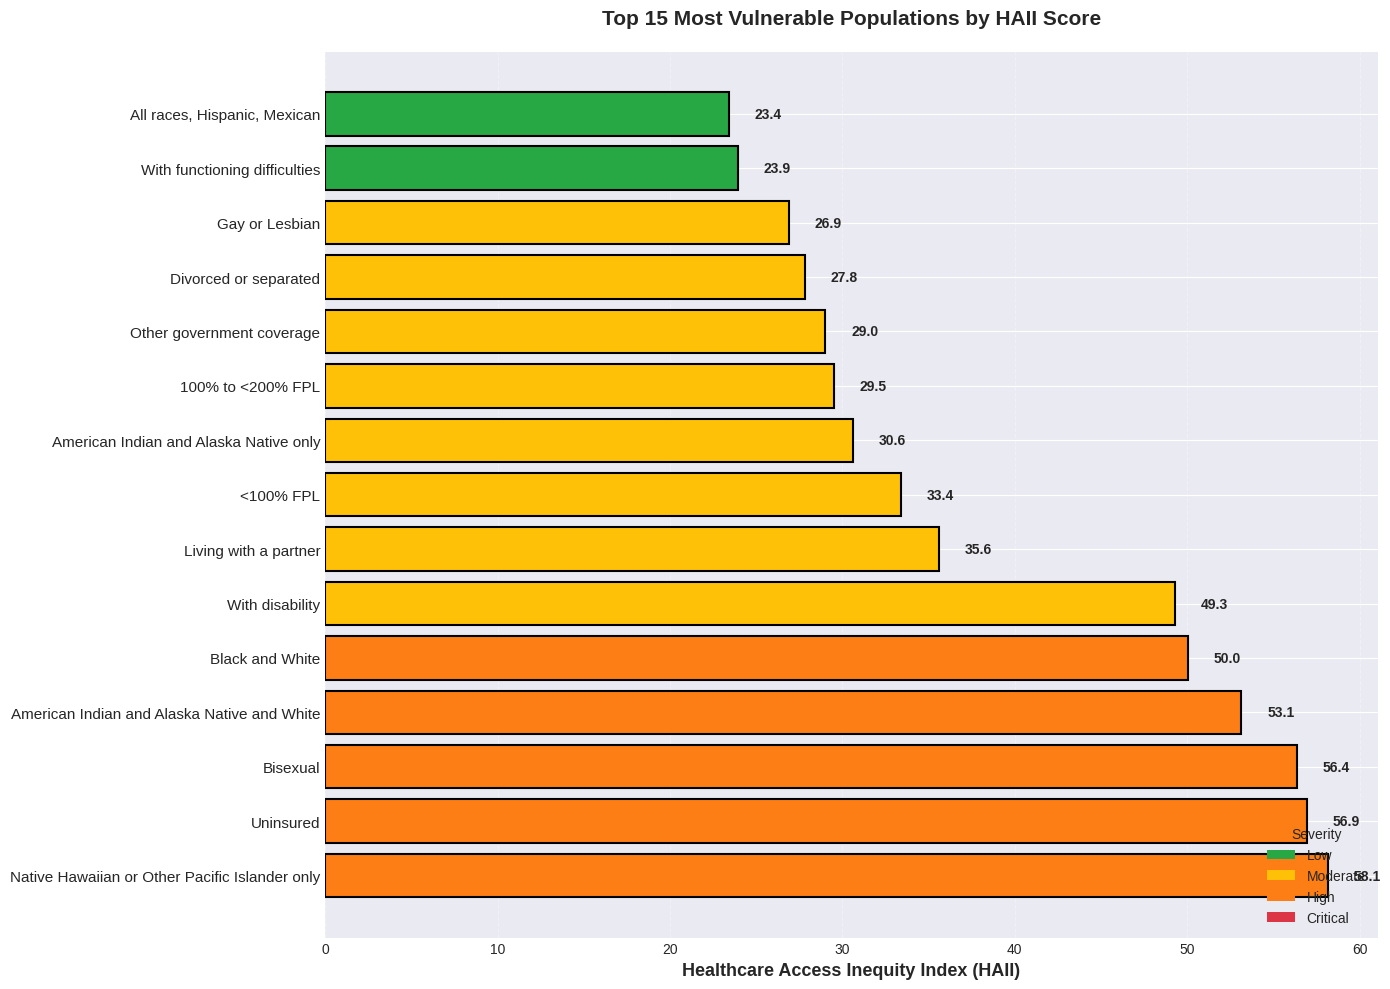

In [ ]:
# Identify Vulnerable Populations
top_15 = feature_matrix.nlargest(15, 'HAII')

fig, ax = plt.subplots(figsize=(14, 10))

colors = {'Low': '#28a745', 'Moderate': '#ffc107', 'High': '#fd7e14', 'Critical': '#dc3545'}
color_map = [colors[sev] for sev in top_15['HAII_severity']]

bars = ax.barh(range(len(top_15)), top_15['HAII'], color=color_map, edgecolor='black', linewidth=1.5)
ax.set_yticks(range(len(top_15)))
ax.set_yticklabels(top_15['SUBGROUP'], fontsize=11)
ax.set_xlabel('Healthcare Access Inequity Index (HAII)', fontsize=13, fontweight='bold')
ax.set_title('Top 15 Most Vulnerable Populations by HAII Score', fontsize=15, fontweight='bold', pad=20)
ax.grid(axis='x', alpha=0.3, linestyle='--')

# Add HAII score labels
for i, (haii, sev) in enumerate(zip(top_15['HAII'], top_15['HAII_severity'])):
    ax.text(haii + 1.5, i, f'{haii:.1f}', va='center', fontsize=10, fontweight='bold')

# Add severity legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=colors[s], label=s) for s in ['Low', 'Moderate', 'High', 'Critical']]
ax.legend(handles=legend_elements, loc='lower right', title='Severity', fontsize=10)

plt.tight_layout()
plt.show()


In [ ]:
# Identify Forgotten Populations
double_burden = feature_matrix[
    (feature_matrix['avg_access_barrier'] > feature_matrix['avg_access_barrier'].quantile(0.75)) &
    (feature_matrix['avg_condition_prevalence'] > feature_matrix['avg_condition_prevalence'].quantile(0.75))
].sort_values('HAII', ascending=False)
print("High access barriers + High disease prevalence\n")
print(double_burden[['SUBGROUP', 'HAII', 'avg_access_barrier', 'avg_condition_prevalence']].to_string(index=False))


High access barriers + High disease prevalence

                                      SUBGROUP      HAII  avg_access_barrier  avg_condition_prevalence
Native Hawaiian or Other Pacific Islander only 58.145254           16.366667                 33.532308
   American Indian and Alaska Native and White 53.133298           11.565000                 29.495902
                               Black and White 50.048661           13.018182                 28.174211
                               With disability 49.301835           12.212500                 37.465646
                         Divorced or separated 27.820063            9.537500                 25.267347
                 With functioning difficulties 23.944632            9.466667                 28.720748
                 No high school diploma or GED 22.364265            8.741667                 24.845238


In [ ]:
# High volatility: Unpredictable access
high_volatility = feature_matrix[
    feature_matrix['avg_volatility'] > feature_matrix['avg_volatility'].quantile(0.75)
].sort_values('HAII', ascending=False)

print(f"\nHIGH VOLATILITY POPULATIONS ({len(high_volatility)} subgroups):")
print(high_volatility[['SUBGROUP', 'HAII', 'avg_volatility', 'avg_yoy_change']].head(10).to_string(index=False))


HIGH VOLATILITY POPULATIONS (19 subgroups):
                                   SUBGROUP      HAII  avg_volatility  avg_yoy_change
                                  Uninsured 56.923810        3.163641       -0.480952
                                   Bisexual 56.354271        2.801718        0.330000
American Indian and Alaska Native and White 53.133298        2.941001       -1.168750
                            Black and White 50.048661        1.819405        0.571429
                            With disability 49.301835        1.274307       -0.080000
                      Living with a partner 35.594996        1.720564       -0.335000
                                  <100% FPL 33.374702        1.420964       -0.595000
     American Indian and Alaska Native only 30.599456        1.604711       -0.327273
                          100% to <200% FPL 29.494618        1.601089       -0.565000
                  Other government coverage 29.001231        3.874891        0.559091


In [ ]:
# Rapid deterioration
deteriorating = feature_matrix[
    feature_matrix['avg_yoy_change'] < feature_matrix['avg_yoy_change'].quantile(0.25)
].sort_values('avg_yoy_change')

print(f"\RAPIDLY DETERIORATING POPULATIONS ({len(deteriorating)} subgroups):")
print(deteriorating[['SUBGROUP', 'HAII', 'avg_yoy_change', 'avg_access_barrier']].head(10).to_string(index=False))

\RAPIDLY DETERIORATING POPULATIONS (19 subgroups):
                                   SUBGROUP      HAII  avg_yoy_change  avg_access_barrier
American Indian and Alaska Native and White 53.133298       -1.168750           11.565000
                                  <100% FPL 33.374702       -0.595000           10.950000
                          100% to <200% FPL 29.494618       -0.565000           10.383333
                      Divorced or separated 27.820063       -0.505000            9.537500
 Medicare only excluding Medicare Advantage 19.482001       -0.495000            4.216667
                                  Uninsured 56.923810       -0.480952           21.492000
               All races, Hispanic, Mexican 23.407911       -0.475000            8.979167
              No high school diploma or GED 22.364265       -0.455000            8.741667
                        All races, Hispanic 20.681758       -0.400000            8.858333
            Not employed - Has never worked 20.90

HAII COMPONENT BREAKDOWN

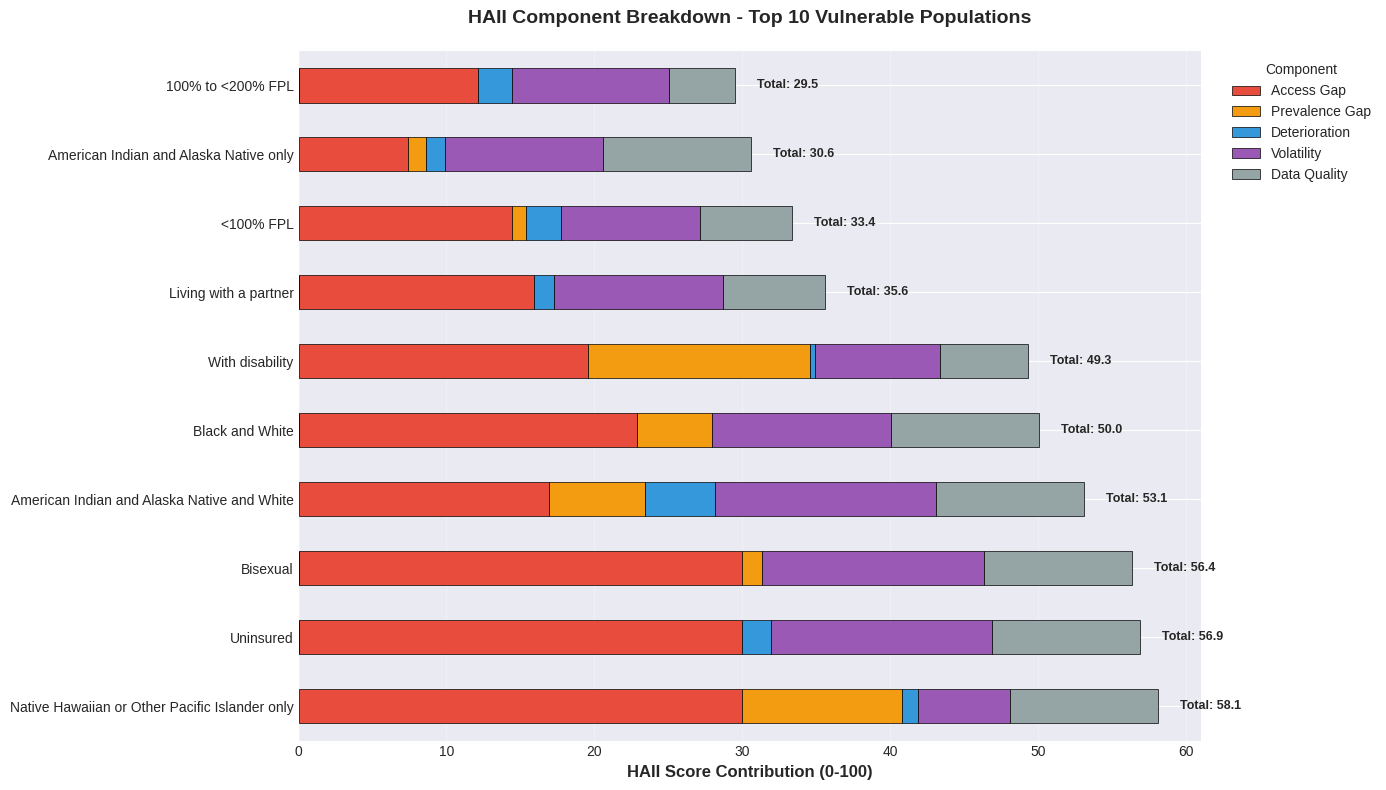

In [ ]:
def calculate_components_detailed(row, baseline):

    # Component 1: Access gap
    access_gap = max(0, (row['avg_access_barrier'] - baseline['avg_access_barrier']) / baseline['avg_access_barrier'])
    access_score = min(access_gap * 100, 100) * 0.30

    # Component 2: Prevalence gap
    prev_gap = max(0, (row['avg_condition_prevalence'] - baseline['avg_condition_prevalence']) / baseline['avg_condition_prevalence'])
    prev_score = min(prev_gap * 100, 100) * 0.25

    # Component 3: Deterioration
    deterioration = -row['avg_yoy_change'] if row['avg_yoy_change'] < 0 else 0
    det_score = min(deterioration * 20, 100) * 0.20

    # Component 4: Volatility
    volatility = row['avg_volatility'] / baseline['avg_volatility']
    vol_score = min(volatility * 50, 100) * 0.15

    # Component 5: Data quality
    quality = row['avg_ci_width'] / baseline['avg_ci_width']
    qual_score = min(quality * 50, 100) * 0.10

    return {
        'Access Gap': access_score,
        'Prevalence Gap': prev_score,
        'Deterioration': det_score,
        'Volatility': vol_score,
        'Data Quality': qual_score
    }

top_10 = feature_matrix.nlargest(10, 'HAII')

components_data = []
for idx, row in top_10.iterrows():
    comps = calculate_components_detailed(row, baseline)
    comps['SUBGROUP'] = row['SUBGROUP']
    components_data.append(comps)

components_df = pd.DataFrame(components_data).set_index('SUBGROUP')

fig, ax = plt.subplots(figsize=(14, 8))

components_df.plot(kind='barh', stacked=True, ax=ax,
                   color=['#e74c3c', '#f39c12', '#3498db', '#9b59b6', '#95a5a6'],
                   edgecolor='black', linewidth=0.5)

ax.set_xlabel('HAII Score Contribution (0-100)', fontsize=12, fontweight='bold')
ax.set_ylabel('')
ax.set_title('HAII Component Breakdown - Top 10 Vulnerable Populations',
             fontsize=14, fontweight='bold', pad=20)
ax.legend(title='Component', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=10)
ax.grid(axis='x', alpha=0.3)

for i, (idx, row) in enumerate(top_10.iterrows()):
    ax.text(row['HAII'] + 1.5, i, f"Total: {row['HAII']:.1f}",
            va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

TEMPORAL TRENDS